<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/Escudo-UNAM-escalable.svg/683px-Escudo-UNAM-escalable.svg.png" alt="" width="200" algin = "center"/></center>
<center><img src="https://lesaunam.com/wp-content/uploads/2019/01/ENES-logo-02.png" alt="" width="200"/></center>
<center><font size="+2">Tecnologías para la Información en Ciencias</font></center>
<center><font size="+3">Introducción a la Ciencia de Datos</font></center>
<center><font size="+4">Proyecto: Web Scraping con Scrapy</font></center>
<center><font size="+2">Alumno: Juan Pablo Maldonado Castro</font></center>
<center><font size="+2">Número de cuenta: 420138620</font></center>
<center><font size="+2">Fecha de entrega: 17 de septiembre de 2021</font></center>


# Introducción

El objetivo de este proyecto es realizar un proceso de Web Scraping en Python utilizando la herramienta de ```Scrapy```. Lo que se busca es poder usar ésta para crear un programa que sea capaz de obtener varios datos de un sitio web. En este caso, se trabajará con la página de https://www.cia.gov/the-world-factbook/, la cual contiene datos de casi o sino todos los países del mundo. 

A partir de los datos que se obtengan de este sitio web, el segundo objetivo es encontrar qué nos dicen los datos a partir de gráficas. Éstas deben procurar visualizar los datos de tal forma que se sigan los 4 principios básicos de presentación de Edward R. Tuffe (maximizar la tasa de tinta de datos, minimizar el factor mentira, minimizar la chatarra gráfica y utilizar escalas apropiadas y etiquetado claro).

La información que queramos analizar a partir de los datos ya va a depender de lo que indiquen las preguntas asignadas del proyecto.

## Problema

Empleando la información que se puede obtener mediante *Scraping* de la página web:

* https://www.cia.gov/the-world-factbook/countries

respondan las siguientes preguntas:

1. ¿Existe alguna relación entre el GDP (PIB) de un país, en términos de su poder adquisitivo, y su porcentaje de usuarios de Internet?
2. ¿Además, la tendencia resulta similar para países con ingreso económico bajo, mediano y alto?

## Desarrollo

Antes de comenzar con el desarrollo del proyecto, es importante importar las librerías que vamos a ocupar para el análisis de los datos. En este caso no va a ser necesario hacer el proceso de ```Scrapy``` dentro de este mismo notebook, ya que se hace por separado en una carpeta llamada **countries**.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

### Scraping del sitio

Para responder las dos preguntas, lo primero que necesitamos es extraer la información del sitio asignado. Al entrar, nos encontraremos con lo siguiente:

<img src='./aux_imgs/img1.png'>

En esta página se encuentra una lista ordenada alfabéticamente de todos los países registrados por la CIA. Además, si le damos click a un nombre de los países, llegaremos a una página con todos los datos disponibles del mismo. Se ve de la siguiente manera:

<img src='./aux_imgs/img2.png'>

Dentro de estas páginas dedicadas a cada país vamos a encontrar para cada uno la mayoría de los datos que ocupamos para este proyecto. Estos son:

* Nombre del país
* Área en $km^2$
* Población (número de habitantes)
* Producto Interno Bruto (GDP per capita)
* Tasa de desempleo
* Tasa de impuestos
* Deuda externa
* Tasa de cambio a dólares
* Número de usuarios de internet
* Porcentaje de usuarios de internet
* Número de aeropuertos
* Carreteras en servicio en $km^2$
* Inversión militar en % del PIB
* Imagen de la bandera nacional
* URL de la imagen de la bandera

Algo a tomar en consideración, es que va a haber países que tengan datos faltantes. Esto va a ser algo con lo que tendremos que lidiar en nuestro proceso de *Data Wrangling*. Para realizar nuestro proceso de Scraping, algo que podemos notar es que en la página con la lista de los países la lista de estos está siendo generada dinámicamente. Esto lo vemos al interactuar con el siguiente botón de flecha:

<img src='./aux_imgs/img3.png'>

Al inhabilitar JavaScript en la página, notamos que este botón no funciona. Pero cuando lo habilitamos, podemos dar click y seguir navegando por la lista de países. Esto nos presenta un problema, ya que todos los elementos que ocupamos de la página no están en un mismo sitio estático. Al tener nuestros países separados en esta lista navegable solo por medio de este botón, tenemos dos opciones para lidiar con este problema.

La primer solución sería hacer un proceso de *Scraping* enfocado a lidiar con sitios dinámicos. La segunda sería buscar una forma alternativa para poder acceder a todos los sitios de los países sin necesidad de preocuparnos de que estén separados por procesos dinámicos de la página web. En este caso trataremos de enfocarnos en la segunda opción ya que personalmente me parece más sencilla.

Para empezar, en lugar de ir directamente a la página de https://www.cia.gov/the-world-factbook/countries/, probemos ir a la sección anterior: https://www.cia.gov/the-world-factbook/. Dentro de ésta, nos encontraremos con la siguiente página inicial:

<img src='./aux_imgs/img4.png'>

Si bajamos dentro de esta misma página, llegaremos a la siguiente sección que puede ser de nuestro interés:

<img src='./aux_imgs/img5.png'>

Podemos observar que hay una lista de las regiones del mundo (este lo vamos a ignorar en el proceso de Scraping). El primer elemento es relacionado a la información general del mundo. Lo interesante es que abajo de él se encuentran listadas todas las regiones del planeta. Si le damos click a alguna de éstas, nos encontraremos con lo siguiente:

<img src='./aux_imgs/img6.png'>

Es una sección de la región que contiene una lista de todos los países dentro de ella. Además, la gran ventaja es que para todas las regiones todos los países listados son accesibles de manera directa en la misma página. Incluso, los nombres listados también nos dirigen al sitio dedicado a la información del país correspondiente. No hay necesidad de manejar datos generados dinámicamente como en la página que habíamos visto inicialmente. 

La desventaja es que entre esta lista de países nos encontramos con elementos que no lo son. Por ejemplo, están la Unión Europea, islas que ya le pertenecen a un país, territorios océanicos, archipiélagos, etc. Esto será algo de lo que no nos vamos a preocupar por esta ocasión porque no son tantos los datos de este tipo, además de que en el futuro los podríamos identificar como datos atípicos dependiendo de sus valores.

Entonces, asumiendo que en todas estas regiones encontramos todos o al menos la gran mayoría de los países del mundo, podemos utilizar estas secciones para hacer un *Scraping* de los datos de los países. Esto sin la necesidad de lidiar con asuntos como el botón que interactúa dinámicamente con los datos de la página. Ahora lo único que ocupamos es:

1. Ingresar inicialmente a la página https://www.cia.gov/the-world-factbook/.
2. Para cada región listada (a excepción de 'World'), ingresar a su hipervínculo correspondiente.
3. Para cada país dentro del sitio de la región, ingresar a su hipervínculo correspondiente.
4. Extraer todos los datos disponibles mencionados previamente de todos los países encontrados. Esto lo podemos hacer con un ```parse_item```de scrapy que se base en los **xpath** de cada dato
5. Exportar todos los datos encontrados a un archivo csv. En el caso de las imágenes, guardarlas en un directorio.

Todo este proceso es realizado con un proyecto de ```Scrapy```, en el cual crearemos un archivo de ```spider.py``` que se encargará hacer una clase que visite todas las regiones y países para así poder extraer los datos de los sitios de estos últimos. La configuración y definiciones realizadas para llevar a cabo este proceso se pueden observar de manera más detallada dentro del directorio **countries** que viene en la carpeta de este proyecto.

El resultado final de este proceso nos devolvió un directorio, **flags**, con todas las imágenes de las banderas encontradas de los países. También nos dio el archivo ```countries_items.csv``` que contiene todos los datos encontrados de cada país que tuvimos disponible en el sitio. 

### Data Wrangling

**Nota**: a lo largo de esta sección va haber muchas partes donde visualizamos los datos en el Notebook ya sea imprimiendo o visualizando los distintos datos del *DataFrame*. Como esto terminaba abarcando mucho espacio, la presentación del Notebook se veía muy cargada e innecesariamente larga. Por esta razón decidí comentar todas las líneas que imprimieran los datos. De todos modos se conservan, para que se tenga idea de cómo se fue realizando este proceso.

Antes de manipular nuestro conjunto de datos, hay que obtenerlo como un *DataFrame* de **pandas**. Para esto, hacemos lo siguiente:

In [2]:
df = pd.read_csv('countries_items.csv')

Algo adicional que podemos hacer, solo por conveniencia, es ordenarlos por orden alfabético respecto a su nombre:

In [3]:
df.sort_values(by=['nombre'], inplace = True, ignore_index=True)
#df

Lo que queremos hacer es manejar los datos de tal forma que podamos hacer interpretaciones y gráficos sobre ellos. Desafortunadamente la manera en que están presentados aquí no es muy conveniente para hacer operaciones de distintos tipos. Las razones son que algunos datos son nulos, otros tienen el valor numérico mezclado con algún texto, también hay algunos que solo tienen como contenido un enunciado que usualmente no tiene ningún valor específico, etc.

Para obtener un *DataFrame* ideal para el propósito de este proyecto haremos las siguientes acciones sobre nuestros datos:
* Toda fila que no tenga un nombre de un país (son típicamente islas) será eliminada del conjunto
* Para todas las columnas cuya información dependa de algún valor numérico como **area**, **poblacion**, **desempleo**, etcétera, vamos a borrar todo el texto de acompañamiento. Esto incluye fechas, enunciados, unidades o signos de cualquier tipo. Lo único que vamos a preservar serán un valor numérico en tipo de dato **float**.
* Una vez que la columna **gdp** está transformada a valores flotantes, vamos a hacer la siguiente transformación a dato categórico. Si:
    * GDP $<$ 50: entonces se considera dato atípico. Por lo tanto se elimina el dato y pasa a ser NaN.
    * 50 $\leq$ GDP $\leq$ 5,000: entonces se considera 'Ingreso bajo'
    * 5,000 $<$ GDP $\leq$ 25,000: entonces se considera 'Ingreso medio'
    * GDP $>$ 25,000: entonce se condiera 'Ingreso alto'.

* Mantener países con datos nulos. A pesar de que no haya algún dato de estos, puede que sigan poseyendo otros que nos puedan beneficiar al análisis que buscamos hacer.

Esto lo hacemos a continuación:

Primero, notemos que hasta abajo del *DataFrame* hay algunas filas que solo tienen **imagen** y **url_imagen**. 

In [4]:
#df.tail(10)

Vamos a eliminarlas porque no nos van a aportar casi nada a nuestros datos. Ni siquiera tienen el nombre del país, porque como podemos observar parecen ser solo unas islas que no poseen de los datos que vamos a analizar. Basta con redefinir nuestro *DataFrame* para que solo almacene las columnas con valores no nulos en la columna de **nombre**. 

In [5]:
#Eliminar filas con nombre de país nulo
df = df[df['nombre'].notna()]
#df.tail(5)

Ahora, todas las filas de nuestro *DataFrame* tienen por lo menos el nombre del país. Lo que sigue es limpiar la columna de **area**. Observemos su comportamiento:

In [6]:
#for area in df['area']:
#    print(area)

Notemos que la cadena de texto sigue un patrón: primero va el número de $km^2$ seguido ya sea de las unidades o de detalles complementarios. Lo malo, es que hay un par de casos donde el valor del área está expresado en escala de millones. Así que vamos a considerarlos y lo que haremos es multiplicar su valor numérico por 1,000,000. 

Lo que haremos para quedarnos únicamente con el valor numérico será separar por espacio nuestra **string** en una lista. Agarraremos únicamente el primer elemento y quitaremos todas las comas que hay en los números; en caso de que éste tenga un punto, transformamos en **float** el valor y lo multiplicamos por un millón. Finalmente transformamos la columna en valores numéricos de manera explícita para que no estén definidos como **string** en el *DataFrame*.

In [7]:
#Obtener valores numéricos de area
aux = df['area']
aux = aux.str.replace(',','')
counter = 0

for l in aux.str.split():
    aux[counter] = l[0]
    if('.' in aux[counter]): #Multiplicar por 1,000,000 los expresados en millones
        aux[counter] = str(float(aux[counter])*1000000) 
    counter += 1

df['area'] = aux
df['area'] = pd.to_numeric(df['area'])
#df['area']

Ya que tenemos toda nuestra columna de área con los valores numéricos por sí solos, sigue modificar la columna de **poblacion**. Si la observamos, tenemos lo siguiente:

In [8]:
#for i in df['poblacion']:
#    print(i)

Vemos que los datos siguen un patrón: el primer número que aparezca en el texto (no necesariamente el primer elemento) será el número de habitantes. Además, suele haber una parte entre paréntesis que indica ya sea la fecha o detalles de los datos. Ya si el valor tiene únicamente texto y si ignoramos el número del año en la fecha dentro de los paréntesis, estamos totalmente seguros de que no hay dato numérico para la población de ese país. Algo que también sucede es que, al igual que en la columna de **area**, hay un dato expresado en unidades de millón.

Así que lo primero que haremos será eliminar toda la sección de paréntesis de la **string** para no tener problemas asumiendo los valores numéricos de las fechas como un dato. Luego vamos a quitar todas las comas de las **string**. Éstas las vamos a separar con un ```split()``` y tomaremos el primer valor numérico que encontremos en la lista como el dato de **poblacion**. En caso de que haya un punto en el dato, lo transformamos a **float** y lo multiplicamos por 1,000,000. Al final pasamos nuestros datos como **float** al *DataFrame*. Vamos a dejar los datos NaN tal como están.

In [9]:
#Obtener valores numéricos de población
aux = df['poblacion'].str.replace('\(.*\)','', regex = True) #Quitando substrings con la fecha de obtención del dato
aux = aux.str.replace(',','')
counter = 0

for l in aux.str.split(): #Encontrando el primer valor numérico encontrado, ya que algunos estaban encerrados en texto
    found = False
    for s in l:
        if '.' in s: #Caso particular donde UK tenía expresado en millones su unidad de población
            aux[counter] = str(float(s)*1000000)
            found = True
            break
            
        if(s.isnumeric()): 
            aux[counter] = s
            found = True
            break
            
    if found == False:
        aux[counter] = "" #Valores sin número, se asumirán como NaN
        
    counter += 1
    
aux.tail(20)
df['poblacion'] = aux
df['poblacion'] = pd.to_numeric(df['poblacion'])
#df['poblacion']

Ya tenemos la columna de **poblacion** únicamente en valores numéricos. Ahora sigue el valor de **gdp**, recordemos la transformación a dato categórico que le habíamos planteado. Pero antes de eso, es necesario poder manejarlo como dato numérico. Así que veamos su patrón:

In [10]:
#for i in df['gdp']:
#    print(i)

El patrón que sigue este valor es tener el valor numérico acompañado del signo \$, luego aparece entre paréntesis la fecha de recopilación del dato. Fuera de eso hay alguno que otro valor nulo por los cuales no nos tenemos que preocupar. Ya no hay casos como el de las unidades expresadas en millón, así que no es necesario considerar esas situaciones.

Lo único que haremos será agarrar el primer elemento de la **string** y luego le quitaremos el signo de \$ y las comas. Esto nos dará la **string** del número, el cual pasaremos como tipo de dato numérico a la columna del *DataFrame*.

In [11]:
aux = df['gdp'].str.split().str[0]
aux = aux.str.replace('$','', regex = False)
aux = aux.str.replace(',','')
df['gdp'] = aux
df['gdp'] = pd.to_numeric(df['gdp'])
#df['gdp']

Ya que tenemos los valores numéricos los transformamos en datos categóricos. Recordemos, si:
* GDP $<$ 50: entonces se considera dato atípico. Por lo tanto se elimina el dato y pasa a ser NaN.
* 50 $\leq$ GDP $\leq$ 5,000: entonces se considera 'Ingreso bajo'
* 5,000 $<$ GDP $\leq$ 25,000: entonces se considera 'Ingreso medio'
* GDP $>$ 25,000: entonce se condiera 'Ingreso alto'

Basta con que definamos una función que regrese el dato categórico basado en las condicionales definidas. Ésta se la aplicamos a la columna y así logramos transformar nuestra columna de **gdp** a como habíamos planteado.

In [12]:
def to_categoric(x):
    if(x < 50):
        return np.nan
    elif (50 <= x and x <= 5000):
        return 'Ingreso bajo'
    elif (5000 < x and x <= 25000):
        return 'Ingreso medio'
    elif (x > 25000):
        return 'Ingreso alto'
    else:
        return np.nan
df['gdp'] = df['gdp'].apply(to_categoric)
#df['gdp']

Ya que tenemos la columna de **gdp** en valores categóricos, ahora vamos a transformar la de **desempleo**. Observemos cómo se comportan los datos:

In [13]:
#for i in df['desempleo']:
#    print(i)

El patrón que siguen todas las **string** es: primero está el número seguido del signo de porcentaje, después está la substring que tiene entre paréntesis la fecha de recopilación del dato. 

Como solo ocupamos el valor numérico, nos quedaremos únicamente con el **float** del porcentaje. Para ello separamos la string con ```split()```, quitamos el signo de porcentaje al número y transformamos este valor de **string** a uno numérico en la columna.

In [14]:
aux = df['desempleo'].str.split().str[0]
aux = aux.str.replace('%','')
df['desempleo'] = aux
df['desempleo'] = pd.to_numeric(df['desempleo'])
#df['desempleo']

Ya tenemos los valores de desempleo expresados como el valor numérico del porcentaje. Lo que sigue es repetir un proceso similar con la columna de **impuestos**. Veamos cómo se comporta:

In [15]:
#for i in df['impuestos']:
#    print(i)

Notemos que todas las **string** siguen el mismo patrón: primero está el número acompañado del signo de porcentaje, el cual es seguido por la *substring* **(of GDP)** y después está la fecha de recopilación del dato en paréntesis.

Para obtener el valor numérico del porcentaje haremos exactamente el mismo procedimiento que con la columna de **deuda**. 

In [16]:
aux = df['impuestos'].str.split().str[0]
aux = aux.str.replace('%','')
df['impuestos'] = aux
df['impuestos'] = pd.to_numeric(df['impuestos'])
#df['impuestos']

Ya tenemos el valor numérico del porcentaje para **impuestos**. Ahora sigue transformar el de **deuda**, para ello primero observamos el comportamiento:

In [17]:
#for i in df['deuda']:
#    print(i)

Notemos que en las **string**: primero está el valor numérico de la deuda acompañado de \$, luego están las unidades en trillones, billones, millones o el valor puro y finalmente está la fecha de recopilación del dato encerrado en paréntesis. 

Para obtener únicamente el valor numérico haremos lo siguiente:
1. Quitar los signos de \$ y las comas de todos los datos
2. Separar la string con ```split()```
3. Verificar que el primer elemento de la lista sea numérico, en caso de que no asumir NaN.
4. Inspeccionar si el segundo elemento de la lista es **trillion**, **billion**, **million** o ninguno de los tres. Si:
    * Es **trillion**: multiplicar por 1,000,000,000,000 el valor  **float** del primer elemento de la lista.
    * Es **billion**: multiplicar por 1,000,000,000 el valor **float** del primer elemento de la lista.
    * Es **million**: multiplicar por 1,000,000 el valor **float** del primer elemento de la lista.
    * No es ninguno: ignorar el caso
4. Si el valor es NaN, mantenerlo así.
5. Transformar a valores numéricos todas las **string** obtenidas y añadirlas a la columna

In [18]:
aux = df['deuda']
aux = aux.str.replace('$','', regex = False)
aux = aux.str.replace(',','', regex = False)

counter = 0
for i in aux.str.split().str[:2]:
    if isinstance(i, list) and len(i)>1:
        if(i[0].isnumeric() or ('.' in i[0])):
            if(i[1] == 'million'):
                aux[counter] = str(float(i[0])*1000000)
            elif(i[1] == 'billion'):
                aux[counter] = str(float(i[0])*1000000000)
            elif(i[1] == 'trillion'):
                aux[counter] = str(float(i[0])*1000000000000)
            else:
                aux[counter] = i[0]
        else:
            aux[counter] = np.nan
    else:
        aux[counter] = np.nan

    counter += 1

df['deuda'] = aux
df['deuda'] = pd.to_numeric(df['deuda'])
#df['deuda']

Ya están los valores numéricos de la columna **deuda** expresados como queríamos. Sigue modificar la columna de **tasa_de_cambio**. Veamos cómo se comportan los datos:

In [19]:
#for i in df['tasa_de_cambio']:
#    print(i)

Vemos que para todas las **string** no nulas, el primer elemento es el valor numérico de la tasa de cambio. Solo está seguido ya sea de fechas o información complementaria. Así que solo basta con hacer ```split()``` a los elementos de la columna, usar el primer valor de la lista obtenida, quitar las comas y finalmente pasarlo como valor numérico en el *DataFrame*. Vamos a dejar los valores nulos tal cual como están en la columna.

In [20]:
aux = df['tasa_de_cambio'].str.split().str[0]
aux = aux.str.replace(',','')

df['tasa_de_cambio'] = aux
df['tasa_de_cambio'] = pd.to_numeric(df['tasa_de_cambio'])
#df['tasa_de_cambio']

La siguiente columna dato cuyos valores numéricos obtendremos será la de **usuarios_internet**. Visualizamos cómo están guardados:

In [21]:
#for i in df['usuarios_internet']:
#    print(i)

Vemos que la mayoría de los datos contienen únicamente un número entero que representa el total de usuarios de internet del país. Pero también hay que considerar los casos donde los datos están representados en unidades de millones. Podemos distinguir a estos últimos por tener un punto decimal en la representación de su valor.

Considerando esto, vamos a borrar las comas de todos los números y hacer ```split()``` a todos los elementos. Si vemos que el primer elemento de la lista obtenida de un dato tiene un punto decimal, lo vamos a multiplicar por 1,000,000. Después de todo esto, vamos a pasar los valores **string** a numéricos en el *DataFrame*. Los valores nulos los vamos a dejar como están.

In [22]:
aux = df['usuarios_internet'].str.replace(',','')
aux =aux.str.split().str[0]
counter = 0

for i in aux:
    if i != i: #Para identificar valores nulos
        aux[counter] = i
    else:
        if('.' in i): #Si tiene punto asumir que está en unidad de millones
            #print(i)
            aux[counter] = str(float(i)*1000000)
    counter += 1
            
df['usuarios_internet'] = aux
df['usuarios_internet'] = pd.to_numeric(df['usuarios_internet'])
#df['usuarios_internet']

Lo que sigue es obtener el valor numérico para la columna **porcentaje_internet**, la cual nos indica el porcentaje de usuarios de internet que hay en la población del país. Para ello observamos sus datos:

In [23]:
#for i in df['porcentaje_internet']:
#    print(i)

Notemos que tenemos exactamente el mismo patrón que el presentado originalmente en la columna de **desempleo**. Así que podemos aplicar exactamente el mismo proceso para obtener el valor numérico del porcentaje. Este es: hacer ```split()``` a las **string**, obtener el primer elemento de la lista, quitar el signo de porcentaje y pasar las **string** obtenidas como valores numéricos al *DataFrame*.

In [24]:
aux = df['porcentaje_internet'].str.split().str[0]
aux = aux.str.replace('%','')

df['porcentaje_internet'] = aux
df['porcentaje_internet'] = pd.to_numeric(df['porcentaje_internet'])
#df['porcentaje_internet']

Ahora que tenemos en buen formato los valores numéricos de la columna de **porcentaje_internet**, pasemos a hacer las modificaciones necesarias a **aeropuertos**. Este valor indica el número de aeropuertos que hay en un país. Observemos su estructura:

In [25]:
#for i in df['aeropuertos']:
#    print(i)

Hay un patrón muy claro en la mayoría de los datos: primero está el número de aeropuertos y luego está seguido por el año en que se registró este dato. Hay también excepciones, una de ellas son los datos nulos y la otra es un dato cuya información es solo una descripción de un aeropuerto antiguo e inservible.

Lo que haremos será quitar las comas de las **string** y hacerles ```split()```, después obtendremos el primer elemento de la lista y verificaremos que sea un valor numérico. En caso de que el primer valor de esta lista no exista o no sea un número, simplemente se asume como **NaN**.

In [26]:
aux = df['aeropuertos']
aux = aux.str.replace(',','')
aux = aux.str.split().str[0]


df['aeropuertos'] = aux
df['aeropuertos'] = pd.to_numeric(aux,errors='coerce')
#df['aeropuertos']

Otra columna cuyos datos debemos modificar es la de **carreteras_km**, que nos da el dato del total de km que hay de carreteras en un país. Veamos la forma de su **string**:

In [27]:
#for i in df['carreteras_km']:
#    print(i)

Veamos que tenemos una estructura parecida a la de la columna pasada de **aeropuertos**. Esta es: primero el número de kilómetros, seguido de la unidad $km$ y hasta el final la fecha de recopilación del dato. Hay algunos casos donde se añaden detalles complementarios sobre las carreteras, pero la posición del valor numérico sigue estando donde mismo. También hay valores nulos y otros que son solo una descripción de la situación. Estos dos últimos casos vamos a asumirlos como valores **NaN** en nuestra transformación.

Para hacer la transformación, aplicaremos exactamente el mismo método que con la columna de **aeropuertos**.

In [28]:
aux = df['carreteras_km']
aux = aux.str.replace(',','')
aux = aux.str.split().str[0]

df['carreteras_km'] = aux
df['carreteras_km'] = pd.to_numeric(df['carreteras_km'], errors='coerce')
#df['carreteras_km']

La última columna de datos que nos falta revisar es la de **inversion_militar**. Ésta nos indica el porcentaje del GDP que se le dedica a la inversión militar. Primero observemos cómo están definidas sus **string**:

In [29]:
#for i in df['inversion_militar']:
#    print(i)

Vemos que la mayoría de los países siguen el siguiente patrón para este dato: primero el valor numérico seguido del signo de porcentaje, después la **substring** *of GDP* y finalmente está el año de recopilación del dato. El resto de los valores son nulos con una excepción, Corea del Norte. En ésta vemos un enunciado que nos detalla estimados del porcentaje de inversión militar que nos indica que ésta está entre el 22% y 24%

Para hacer la transformación que queremos, lo primero que haremos será lidiar con el caso atípico de Corea del Norte. A éste le asignaremos directamente el valor en **string** de la media de los porcentajes de inversión militar que nos describen. En este caso, 23%. Para el resto de la columna, primero quitaremos los signos de porcentaje, después haremos un ```split()``` y consideraremos al primer valor de la lista como nuestro dato. Los valores nulos se mantendrán tal cual están. Finalmente pasamos nuestros datos de  **string** a valores numéricos en el *DataFrame*.

In [30]:
df.loc[df['nombre'] == 'Korea, North', 'inversion_militar'] = '23'

aux = df['inversion_militar'].str.replace('%','')
aux = aux.str.split().str[0]

df['inversion_militar'] = aux
df['inversion_militar'] = pd.to_numeric(df['inversion_militar'], errors='coerce')
#df['inversion_militar']

Un paso que es opcional para el conjunto de datos que estameos manejando es el limpiar nuestras columnas **image_name** y **image_urls**. A pesar de que estos datos no los vamos a manipular, creo que puede ser bueno eliminar todos los datos que no correspondan de manera adecuada a esta columna. Veamos la columna de **image_name**:

In [31]:
#for i in df['image_name']:
#    print(i)

Lo que sucede es que en el proceso de *Scraping* obtuvimos URLs a pesar de que no hubiera imágenes disponibles de la bandera. Como estas URLs no tienen al final de su dirección el nombre de la imagen que termina en ```.jpg```, esto nos indica que realmente no tienen una imagen y por lo tanto no deberían ir pertenecer a ninguna de las dos columnas.

Entonces vamos a hacer nulos los valores de las columnas **image_name** e **image_urls** si no terminan en ```.jpg```.

In [32]:
counter = 0
for i in df['image_name']:
    #print(i)
    if '.jpg' not in i:
        #print(i)
        df.loc[df.index[counter], 'image_name'] = np.nan
        df.loc[df.index[counter], 'image_urls'] = np.nan
    counter += 1
    
#for i in df['image_name']:
#    print(i)

Ahora sí tenemos todos los datos en valores numéricos que podemos manipular para hacer distintas operaciones sobre ellos. Las primeras filas de nuestro *DataFrame* se ven de la siguiente manera.

In [33]:
df.head(10)

,nombre,continente,area,poblacion,gdp,desempleo,impuestos,deuda,tasa_de_cambio,usuarios_internet,porcentaje_internet,aeropuertos,carreteras_km,inversion_militar,image_name,image_urls
0,Afghanistan,South Asia,652230.0,37466414.0,Ingreso bajo,23.90,11.2,2.840000e+08,7.870,4717013.0,13.50,46.0,34903.0,1.2,AF-flag.jpg,https://www.cia.gov/the-world-factbook/static/...
1,Akrotiri,Europe,123.0,18195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,AX-flag.jpg,https://www.cia.gov/the-world-factbook/static/...
2,Albania,Europe,28748.0,3088385.0,Ingreso medio,5.83,27.6,9.311000e+09,102.430,2196613.0,71.85,3.0,3945.0,1.3,AL-flag.jpg,https://www.cia.gov/the-world-factbook/static/...
3,Algeria,Africa,2381740.0,43576691.0,Ingreso medio,11.70,32.3,5.574000e+09,131.085,24819531.0,59.58,149.0,104000.0,6.0,AG-flag.jpg,https://www.cia.gov/the-world-factbook/static/...
4,American Samoa,Australia - Oceania,224.0,46366.0,Ingreso medio,29.80,37.8,NaN,1.000,17000.0,31.30,3.0,241.0,NaN,AQ-flag.jpg,https://www.cia.gov/the-world-factbook/static/...
5,Andorra,Europe,468.0,85645.0,Ingreso alto,3.70,69.0,0.000000e+00,0.885,78483.0,91.57,NaN,320.0,NaN,AN-flag.jpg,https://www.cia.gov/the-world-factbook/static/...
6,Angola,Africa,1246700.0,33642646.0,Ingreso medio,6.60,29.3,4.208000e+10,172.600,4353033.0,14.34,102.0,26000.0,1.7,AO-flag.jpg,https://www.cia.gov/the-world-factbook/static/...
7,Anguilla,Central America,91.0,18403.0,Ingreso medio,8.00,46.7,4.104000e+07,2.700,14211.0,81.57,1.0,175.0,NaN,AV-flag.jpg,https://www.cia.gov/the-world-factbook/static/...
8,Antigua and Barbuda,Central America,443.0,99175.0,Ingreso medio,11.00,19.6,4.412000e+08,2.700,72870.0,76.00,3.0,1170.0,NaN,AC-flag.jpg,https://www.cia.gov/the-world-factbook/static/...
9,Argentina,South America,2780400.0,45864941.0,Ingreso medio,9.84,18.9,2.785240e+11,82.034,33203320.0,74.29,916.0,281290.0,0.7,AR-flag.jpg,https://www.cia.gov/the-world-factbook/static/...


Finalmente, para corroborar que el tipo de dato es adeucado podemos checar los datos numéricos sean **float** y el resto de las columnas, incluyendo **gdp**, sean de tipo **object**.

In [34]:
df.dtypes

nombre                  object
continente              object
area                   float64
poblacion              float64
gdp                     object
desempleo              float64
impuestos              float64
deuda                  float64
tasa_de_cambio         float64
usuarios_internet      float64
porcentaje_internet    float64
aeropuertos            float64
carreteras_km          float64
inversion_militar      float64
image_name              object
image_urls              object
dtype: object

Vemos que las columnas sí tienen el tipo de dato deseado para cada una. Ahora podemos pasar a hacer nuestro análisis de los datos para responder las preguntas planteadas en el problema del proyecto.

### 1 y 2. Relación entre GDP (PIB) de un país y su porcentaje de usuarios de Internet. 

Queremos identificar si hay alguna relación entre el GDP (PIB) de un país en términos de su poder adquisitivo, y su porcentaje de usuarios de Internet. Además, queremos ver si esta relación es algo consistente en los distintos niveles del ingreso económico, ya sea bajo, mediano o alto.

Recordemos que el poder adquisitivo de un país lo habíamos definido como un dato categórico, que se basaba en las siguientes reglas:
1. GDP $<$ 50 = Dato atípico (no se considera)
2. 50 $\leq$ GDP $\leq$ 5,000 = Ingreso bajo
3. 5,000 $<$ GDP $\leq$ 25,000 = Ingreso medio
4. GDP $>$ 25,000 = Ingreso alto

**Graficando y analizando los datos**

Para poder observar esta relación podemos realizar gráficas que nos ayuden a visualizar la distribución de los datos para las dos variables que queremos analizar. Estas dos variables son las que encontramos en nuestra columna de **gdp** y la de **porcentaje_internet**. Así que lo primero que haremos será crear un *DataFrame* auxiliar donde mantendremos aquellos países que tengan ambos datos presentes y eliminaremos a todo país que tenga al menos un dato nulo de estas dos columnas.

In [35]:
df_pi_gdp = df[(df['porcentaje_internet'].notna()) & (df['gdp'].notna())]
#df_pi_gdp['porcentaje_internet'].isnull().value_counts()
#df['gdp'].isnull().value_counts()

Ahora tenemos que plantear qué tipo de gráficas haremos para observar la posible relación. Hay que considerar que una de nuestras variables es de tipo categórica (**gdp**), mientras que la otra es continua (**porcentaje_internet**). Por esta razón, debemos enfocarnos en gráficas que muestren claramente el valor del porcentaje de usuarios de internet para cada categoría de ingreso económico de todos los países. 

Normalmente, cuando queremos ver la relación entre dos variables se hace una diagrama de distribución a manera de **scatter plot**. Pero como ese tipo de diagramas están enfocados principalmente a una aplicación con variables continuas, tenemos que escoger una ligera variación de ellos. Una alternativa similar al **scatter plot**, pero que podemos aplicar sobre una variable continua y una categórica es la gráfica de tipo **swarm** que ofrece ```seaborn```. En ésta podemos establecer en el eje de las *y* el porcentaje de usuarios de Internet que tiene el país y en el centro tendremos una columna donde se irán acumulando puntos cuyo valor en el eje *y* depende de su porcentaje de usuarios. Estos puntos estarán coloreados acorde a la categoría de ingreso económico a la que pertenezca el país. Esto se ve de la siguiente manera:

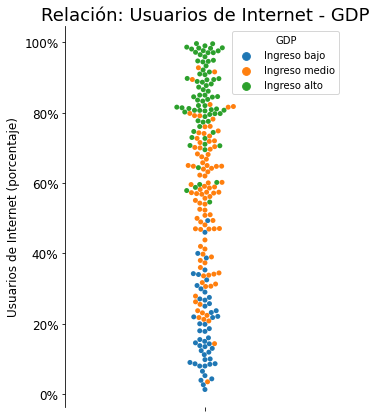

In [36]:
import matplotlib.ticker as mtick # Para añadir porcentajes a las tick

fig, ax = plt.subplots(figsize=(5,7))

sns.swarmplot(y=df_pi_gdp['porcentaje_internet'],
              hue =df_pi_gdp['gdp'],
              x=[""]*len(df_pi_gdp['porcentaje_internet']),
              s = 5)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tick_params(axis="y", labelsize=12)

plt.legend(title="GDP")

plt.ylabel('Usuarios de Internet (porcentaje)', size=12)

plt.title("Relación: Usuarios de Internet - GDP", size = 18)
plt.show()

A partir de aquí ya podemos empezar a notar cierta relación entre **gdp** y **porcentaje_internet**. Vemos cómo los países de ingreso bajo tienden a acomodarse en la sección más baja del eje *y*, indicándonos que tienen un porcentaje bajo de usuarios de Internet; aproximadamente entre 0% y 40%. Los países de ingreso medio se esparcen casi por todo el rango de porcentajes, pero lo notable es que se concentran mayormente en la sección media de la columna que está aproximadamente entre 40% y 80%. Finalmente, los países de ingreso alto son los que tienen los porcentajes más altos de usuarios de Internet, la mayoría de ellos siendo mayores a 80%; sin embargo hay ciertas excepciones que llegan a descender incluso a casi 50%.

Esta gráfica nos ayuda a darnos una idea general sobre lo que ya mencionamos, pero hay más formas de visualizar este comportamiento de los datos. Probemos de nuevo con las **swarm plot**, pero esta vez separemos en distintas columnas nuestras categorías de datos: 

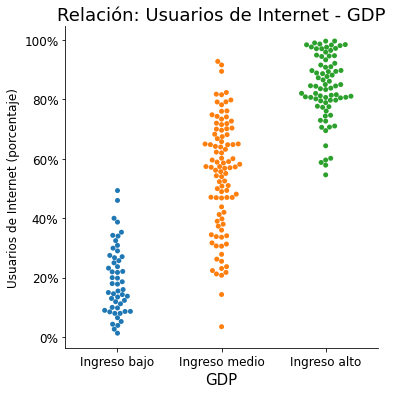

In [37]:
import matplotlib.ticker as mtick # Para añadir porcentajes a las tick

sns.catplot(x='gdp', y='porcentaje_internet',kind='swarm', data=df_pi_gdp, height = 5)

plt.tick_params(axis="x", labelsize=12, rotation = 0)
plt.tick_params(axis="y", labelsize=12)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Usuarios de Internet (porcentaje)', size=12)
plt.xlabel('GDP', size = 15)
plt.title("Relación: Usuarios de Internet - GDP", size = 18)
plt.show()

Observemos cómo la columna de ingreso bajo tiene los puntos cargados hacia abajo en el eje de porcentajes. Aunque también podemos ver que algunos de los países en esta categoría tienen mayor porcentaje de usuarios de internet que algunos de los que tienen ingreso medio. 

En la segunda columna vemos cómo hay una mayor variación en los porcentajes de usuarios de Internet de los países. Los datos se esparcen mucho más a comparación del caso de la columna de ingreso bajo y la de ingreso alto, si nos fijamos bien, sus valores se distribuyen prácticamente por casi todo el rango de porcentajes disponible. A pesar de esto, sigue siendo notorio que la mayor concentración de puntos de la columna de ingreso medio se encuentra entre el 40% y 80% que mencionamos previamente.

Finalmente, en la columna de ingreso alto podemos observar que todos los puntos están arriba del 50%. Además la mayoría de ellos se encuentran acumulados aproximadamente entre el 75% y 100%. Los rangos más altos de porcentajes de usuarios de Internet le pertenecen a los países de ingreso alto; sin embargo, también hay países de ingreso medio que tienen mayores porcentajes que algunos de los de ingreso alto. Algo que sí podemos confirmar es que todos los países de ingreso alto tienen un mayor porcentaje de usuarios de Internet que todos los países de ingreso bajo.

Esta separación de en columnas nos permitió visualizar de manera más clara cómo se distribuía el porcentaje de usuarios de Internet de los países para cada categoría de ingresos. Lo que fue importante observar es cómo no hay un rango de porcentajes completamente exclusivo para todos los valores de una categoría, ya que para todas las categorías había países de un ingreso distinto que tenían porcentajes parecidos, menores, mayores o iguales.

Algo que sería deseable observar, son los rangos generales en donde se concentran los datos de cada clase. De esta forma podemos determinar en qué secciones se enfocan los porcentajes de usuarios de Internet para cada categoría de ingreso económico. Además, podremos observar qué tan separados están estos rangos estimados los unos de los otros para la mayoría de los datos. Una forma de visualizar esto es con gráficas de caja, **box plot**s, que trazan un rectángulo en la sección de mayor concentración de datos para cada categoría. También, nos ayudan a identificar el rango total de todos los datos y a identificar los datos aberrantes de cada categoría si se salen del rango máximo esperado.

Primero grafiquémoslo de manera tal que se identifique visualmente la construcción de los **box plot** con los puntos que observamos en los **swarmplot** previamente realizados.

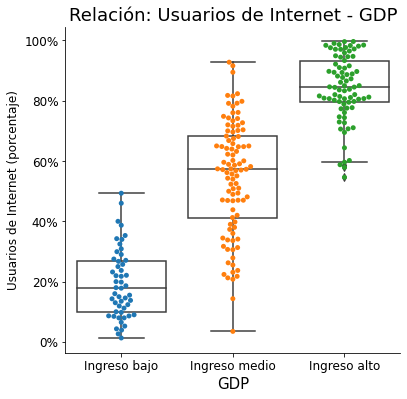

In [38]:
fig, ax = plt.subplots(figsize=(6,6))

sns.swarmplot(x='gdp', y='porcentaje_internet', data=df_pi_gdp)
sns.boxplot(x = 'gdp', y="porcentaje_internet", data=df_pi_gdp, boxprops={'facecolor':'None'})


plt.title("Relación: Usuarios de Internet - GDP", size = 18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tick_params(axis="x", labelsize=12, rotation = 0)
plt.tick_params(axis="y", labelsize=12)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Usuarios de Internet (porcentaje)', size=12)
plt.xlabel('GDP', size = 15)
plt.title("Relación: Usuarios de Internet - GDP", size = 18)
plt.show()

Ya que observamos esto, no está de más dibujar únicamente los **box plot** obtenidos para cada categoría de **gdp**:

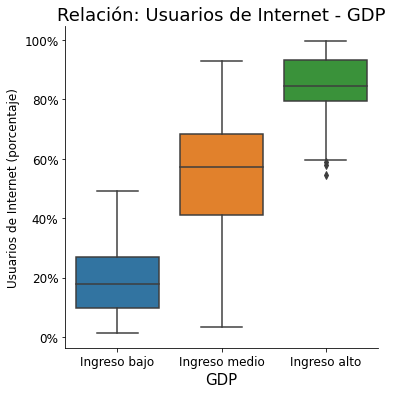

In [39]:
sns.catplot(x='gdp', y='porcentaje_internet',kind='box', data=df_pi_gdp)

plt.title("Relación: Usuarios de Internet - GDP", size = 18)

plt.tick_params(axis="x", labelsize=12, rotation = 0)
plt.tick_params(axis="y", labelsize=12)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Usuarios de Internet (porcentaje)', size=12)
plt.xlabel('GDP', size = 15)
plt.title("Relación: Usuarios de Internet - GDP", size = 18)
plt.show()

Notemos que el rango total de los datos de cada categoría está indicado por la línea gris vertical de cada columna. Como ya habíamos notado en las figuras previas, los países de ingreso medio se expanden por casi todo el rango de porcentajes; los de ingreso bajo se quedan en rangos de entre 0% y aproximadamente el 50%; y los países de rango alto están por arriba del 60% con algunos datos aberrantes por debajo.

Lo interesante de esta gráfica son las cajas que se construyeron. Éstas nos indican los rangos de mayor concentración para los porcentajes de usuarios de Internet de cada categoría. Veamos cómo el rango de ninguna caja se cruza con el de otra, todas ellas son claramente separables en el rango de porcentajes disponible. 

Otra característica es la distribución de los datos que nos indica el tamaño de las cajas. La columna cuyos datos están mas esparcidos, la del medio, tiene la caja de mayor tamaño; indicándonos que los porcentajes para estos países varían más a lo largo de este rango. Mientras menos varían los datos, la caja se va haciendo más pequeña. Como ejemplo notamos que la caja verde, la de ingreso alto, es la más pequeña porque los datos están mucho más concentrados en ese rango más pequeño que el de ingreso medio y bajo.

Una gráfica que nos señala visualmente casi lo mismo que estas gráficas de **box plot**, son las de violín que ofrece ```seaborn```. La idea de éstas es trazar una figura parecida a un violín y en los valores del eje *y* donde haya mayor concentración de datos, más ancho será el violín; mientras menos datos haya en determinado valor más angosto será el violín en ese punto de *y*. Éstas las visualizamos de la siguiente forma:

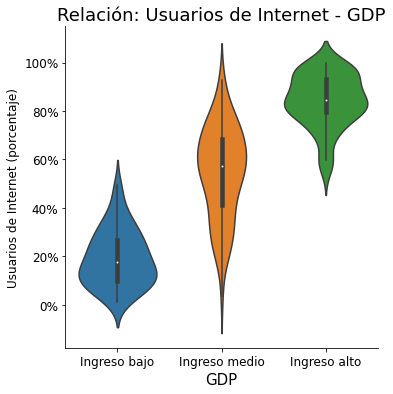

In [40]:
sns.catplot(x='gdp', y='porcentaje_internet',kind='violin', data=df_pi_gdp)

plt.title("Relación: Usuarios de Internet - GDP", size = 18)

plt.tick_params(axis="x", labelsize=12, rotation = 0)
plt.tick_params(axis="y", labelsize=12)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Usuarios de Internet (porcentaje)', size=12)
plt.xlabel('GDP', size = 15)
plt.title("Relación: Usuarios de Internet - GDP", size = 18)
plt.show()

Esta gráfica representa de manera clara las observaciones que realizamos en las figuras pasadas. Otra forma que puede haber de visualizar la relación entre el GDP y el porcentaje de usuarios de Internet es con un histograma de frecuencias. Si usamos en el eje *y* la frecuencia y en el *x* el porcentaje de usuarios de internet, podemos colocar barras unas encima de las otras. Cada una de estas barras tiene un color que también representa la categoría de ingreso económico.

Al poder observar una gráfica de este tipo podremos observar claramente en qué rangos se encuentran los porcentajes de usuarios de cada categoría. También, ayudará a visualizar la cantidad total de países que comparten porcentajes similares. Además, el largo de cada barra y la cantidad de ellas también ayudan a identificar qué tan común es cierto porcentaje en determinado rango y categoría.

Graficando esto tenemos:

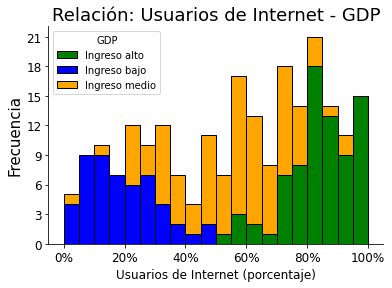

In [41]:
from matplotlib.ticker import MaxNLocator #Para forzar que la escala del eje y sea representada forzosamente en enteros

bins = [i*5 for i in range(0,21)]

df_pi_gdp.pivot(columns = 'gdp').porcentaje_internet.plot(kind = 'hist',
                                                          stacked = True,
                                                          bins = bins,
                                                          color=['g','b','orange'],
                                                          edgecolor = 'black')

plt.title("Relación: Usuarios de Internet - GDP", size = 18)

plt.tick_params(axis="x", labelsize=12, rotation = 0)
plt.tick_params(axis="y", labelsize=12)

plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel('Usuarios de Internet (porcentaje)', size=12)
plt.ylabel('Frecuencia', size = 15)


plt.legend(title="GDP")
plt.title("Relación: Usuarios de Internet - GDP", size = 18)
plt.show()

Podemos hacer las mismas observaciones que ya hemos estado comentando, pero esta vez relacionándolas con este histograma.

Lo primero que notamos es que hay barras azules en todos los intervalos del histograma entre 0% y 50%. Esto nos indica claramente que todos los países de ingreso bajo tienen a lo mucho un 50% de su población como usuarios de Internet. También las frecuencias más altas de estos países en azul están entre el 5% y 35%, diciéndonos que para los países de ingreso bajo es raro que se acerquen incluso a tener un 50% de usuarios de Internet.

Pasando a los países de ingreso medio, lo que observamos es que tienen barras a lo largo de casi todo el histograma. Lo distinguible es que las barras de mayor tamaño se encuentran entre el 45% y el 80%. Luego hay barras de tamaño "mediano" entre el 20% y 45%. Fuera de esos rangos, las barras naranjas comienzan a ser muy pequeñas. Lo que esto nos indica es que para países de ingreso medio lo más probable es que tengan un porcentaje de usuarios de Internet entre el 45% y 80%; pero aunque sea en casos muy raros pueden tener un porcentaje muy pequeño o uno muy alto.

Terminando con los países de ingreso alto, notemos que sus barras comienzan a aparecer en el 50% y llegan hasta el 100%. También, las barras se vuelven muy grandes a partir del 80%. Luego entre 70% y 80% son medianas; y entre 50% y 70% las barras son muy pequeñas. Esto nos dice que para los países de ingreso alto es muy común tener un porcentaje de usuarios de Internet entre el 80% y 100%; y que es poco común para uno de ellos tener menos del 70% de usuarios. Y ya no existe ni un solo país de ingreso alto que tenga un porcentaje de usuarios menor a 50%.

Una última forma de visualizar los datos es con polígonos de frecuencia. El comportamiento de estos será muy similar al del histograma que hicimos, pero esta vez los valores de las frecuencias de las categorías no se encimarán unas sobre las otras. Ahora el valor total en el eje *y* que veamos no será el de la frecuencia total de las tres categorías, sino el de una sola. Ya la categoría la identificamos por el color de la línea. Esto se ve como se muestra a continuación:

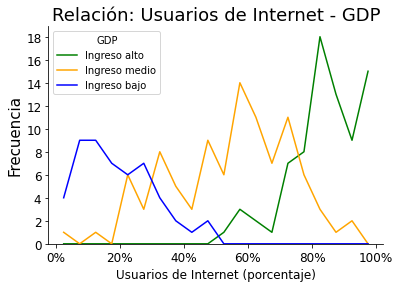

In [42]:
# Ingreso alto
sns.histplot(data = df_pi_gdp.loc[df_pi_gdp['gdp'] == "Ingreso alto", 'porcentaje_internet'],
             bins = bins,
            element = 'poly',
            fill = False,
            color = 'green',
            label = 'Ingreso alto')

#Ingreso medio
sns.histplot(data = df_pi_gdp.loc[df_pi_gdp['gdp'] == "Ingreso medio", 'porcentaje_internet'],
             bins = bins,
            element = 'poly',
            fill = False,
            color = 'orange',
            label = 'Ingreso medio')

#Ingreso bajo
sns.histplot(data = df_pi_gdp.loc[df_pi_gdp['gdp'] == "Ingreso bajo", 'porcentaje_internet'],
             bins = bins,
            element = 'poly',
            fill = False,
            color = 'blue',
            label = "Ingreso bajo")

plt.title("Relación: Usuarios de Internet - GDP", size = 18)

plt.tick_params(axis="x", labelsize=12, rotation = 0)
plt.tick_params(axis="y", labelsize=12)

plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel('Usuarios de Internet (porcentaje)', size=12)
plt.ylabel('Frecuencia', size = 15)

plt.legend(title="GDP")
plt.title("Relación: Usuarios de Internet - GDP", size = 18)
plt.show()

Sucede justo lo mismo que ya hemos mencionado con el histograma de frecuencia. Pero además de mostrarnos lo que ya vimos en el histograma, tenemos una ventaja adicional en esta figura: es totalmente reconocible en qué rango predomina cada categoría de GDP. Como ahora las frecuencias no están encimadas, podemos comparar los valores que hay en todas las categorías sin mayor dificultad.

Notemos como la mayoría de los datos entre el 0% y el 30% le pertenecen a los países con ingreso bajo. Los países de ingreso medio predominan en los porcentajes de usuarios entre un 30% y 75% (siendo así los que predominan en el rango de porcentajes más amplio). De 75% en adelante está más que claro que la mayoría de los países son de ingreso alto.

También es notable, como en las observaciones del histograma, que sigue habiendo países de ingreso medio con porcentajes entre 0% y 30%, pero en menor medida que los de ingreso bajo. Hay países de ingreso bajo entre el 30% y 50%, aunque son menos comunes que los de ingreso medio en este mismo rango. Pasa una situación similar en el rango 50% y 75% para los países de ingreso alto y medio. Por último, los de ingreso medio también aparecen entre 75% y 95%, pero no aparecen tanto aquí como los países de ingreso alto.

Algo interesante de observar es la distribución de la frecuencia de los porcentajes. Notemos cómo aproximadamente en el centro de los rangos donde predomina cada categoría, ésta misma tiene un punto máximo. Hacia los lados del máximo la distribución de la frecuencia empieza a decrecer hasta llegar al límite del rango o bajar hasta 0.

Por ejemplo, vemos cómo el polígono de frecuencia del ingreso bajo tiene su punto de máximo de frecuencia más o menos en el medio del intervalo donde predomina (0% - 30%) y ya va decreciendo hacia los lados. Como está en la esquina izquierda, pues su decrecimiento se detiene pronto conforme avanzamos hacia la izquierda; pero hacia la derecha decrece de tal forma que llega hasta frecuencia 0 al alcanzar prácticamente el 50%.

El caso del polígono de frecuencia del ingreso medio presenta algo similar. Solo que esta vez, como se encuentra en el medio, su decrecimiento no se ve interrumpido por el límite del rango del porcentaje y se expande hacia los dos lados del dominio. Este comportamiento le permite abarcar prácticamente todo el rango de porcentajes disponible (con la excepción de valores mayores a 95%). Parece aproximadamente una distribución de tipo normal.

Y el caso de los países de ingreso alto, es igual que con los de ingreso bajo. Las únicas diferencias son que ahora se encuentra en la sección elevada de los porcentajes, que su punto máximo inicial es mucho mayor y su decrecimiento es más rápido. 

**Respuestas**

Ya que analizamos y graficamos la relación de los datos entre el porcentaje de usuarios de Internet y el nivel de ingreso económico en términos de GDP, podemos llegar a ciertas conclusiones para responder las preguntas planteadas al inicio.

1. ¿Existe alguna relación entre el GDP (PIB) de un país, en términos de su poder adquisitivo, y su porcentaje de usuarios de Internet?

Sí existe una relación entre el GDP de un país y el porcentaje de usuarios de Internet. Como observamos en las gráficas que hicimos, los países con GDP de ingreso bajo tienden a tener porcentajes de usuarios bajos también (la mayoría de estos estando entre el 5% y 30%). Esto los vuelve los países con menor uso de Internet para sus habitantes de todas las categorías.

Los países con ingreso alto, tienden en su mayoría a tener un porcentaje alto (entre 70% y 100%). Solo una minoría de estos presenta porcentajes entre 50% y 70%. Haciendo a esta categoría a aquella con los porcentajes de usuarios de Internet más elevados de todo el conjunto de datos.

Los países con ingreso medio tienen porcentajes en casi todos los rangos, pero en su mayoría se concentran en un rango medio entre los rangos de las otras categorías. En general, sus porcentajes de usuario predominan sobre las otras categorías entre el 30% y 75% de usuarios de Internet.

Con esto, concluimos que la relación entre estas dos variables es parecida o aproximada a una correlación positiva. Esto nos indica a que conforme aumenta el valor de una variable, la otra también aumenta; si disminuye, la otra hace lo mismo. Esto no lo vemos tal cual con valores continuos, pero es notable con la variable categórica de GDP y la continua del porcentaje. Vemos que los porcentajes de usuarios de Internet más bajos suelen pertenecer en su mayoría a los países de ingreso económico bajo; los porcentajes en rango medio a los de ingreso económico medio; y los porcentajes más altos le pertenecen mayormente a los países de mayor ingreso económico.

2. ¿Además, la tendencia resulta similar para países con ingreso económico bajo, mediano y alto?

Sí, recordemos por nuestra respuesta anterior que: a mayor GDP, mayor será la probabilidad de tener un porcentaje alto de usuarios de internet; a menor GDP, mayor probabilidad de tener un porcentaje bajo de usuarios de Internet. Esto sucede para todas nuestras tres categorías de ingresos con porcentajes bajos, medios y altos de usuario relacionados con GDPs de ingreso bajo, medio y alto respectivamente.

Pero esto no es una afirmación total debido a que estamos haciendo generalizaciones basadas en los rangos donde se enfocaban la mayoría de los porcentajes de usuarios de los países de cada categoría. Lo que hay que tomar en consideración es que puede haber países de ingreso económico bajo con un porcentaje medio; países de ingreso económico medio con porcentajes de usuarios de Internet bajos y altos; y finalmente, países de ingreso económico alto con porcentajes de usuarios de Internet en rangos medios. Sin embargo, todos estos casos que acabamos de mencionar resultan ser la minorías en estos rangos. Recordando el polígono de frecuencias, cada categoría de ingreso económico predominaba en determinada región, pero esta empezaba a decrecer y tener menor frecuencia en los rangos de las otras categorías.

Algo que cabe resaltar es que esta tendencia, a pesar de cumplirse, no se va a distribuir en intervalos iguales a lo largo del dominio de porcentajes. Primero tenemos la región donde aparecen principalmente países de ingreso bajo: 0% - 30%, la cual abarca un 30% de nuestro dominio. Luego está la sección para donde predominan los países de ingreso medio: 30% - 75%, aquí se va un 45% de nuestro dominio total. Al final están los países de ingreso alto que abarcan el menor rango de porcentajes disponible: 75% - 100%, el cual da un total del 25%. Esto nos indica que la tendencia se distribuye en intervalos irregulares, siendo del 30%, 45% y 25% para ingresos económicos, bajos, medios y altos respectivamente.

Considerando todo esto, concluimos, que a pesar de que el porcentaje de usuarios de Internet en distintas categorías de poder adquisitivo pueda llegar a ser similar entre ellas, va a haber regiones para cada una de ellas donde va a predominar más. siendo así que determinan de manera general el poder adquisitivo de un país basado en la región que se encuentre el porcentaje. Este comportamiento termina definiendo la zona de mayor frecuencia para cada categoría. Formando de esta manera una partición en tres intervalos irregulares del rango de porcentajes, donde cada uno pertenece a una categoría de poder adquisitivo ya mencionado anteriormente. Dándonos de esta forma una tendencia (de aproximados y distintos tamaños de rango para cada categoría) definida por lo siguiente:

Si (porcentaje de usuarios de Internet de un país = PI):

1. 0%$\leq$PI$<$30%: probablemente será un país con un GDP de ingreso bajo.
2. 30% $\leq$ PI $<$ 75%: probablemente será un país con un GDP de ingreso medio.
3. 75% $\leq$ PI $\leq$ 100%: probablemente será un país con un GDP  de ingreso alto.

## Conclusiones

A partir de los datos que obtuvimos, las gráficas que hicimos y las interpretaciones realizada podemos decir que el GDP de un país en términos de poder adquisitivo sí tiene una relación con el porcentaje de usuarios de Internet que tiene; vimos que era algo similar al comportamiento de una correlación positiva. Esto lo observamos en todas nuestras figuras, viendo cómo hay ciertos rangos de porcentajes donde es más común encontrarnos con alguna categoría de ingreso económico que con otras. De esta forma fue posible observar una tendencia que nos permitía hacer una generalización donde definíamos a partir de un porcentaje de usuarios de Internet de un país, cuál era el nivel de ingreso económico más probable de éste. 

Pienso que todo el desarrollo de este proyecto me dejó aprendizajes de distintos elementos necesarios para hacer un manejo de datos a nivel introductorio.

El primer reto fue el de obtener nuestros datos. Ahora que ya no se me dio un conjunto de datos directamente, fue necesario aprender a utilizar una nueva herramienta: **Scrapy**. Esta resultó muy útil para poder entrar a la página del CIA y obtener toda la información que pudiera de los países. Para llevarlo acabo, una de las partes más importantes fue estar navegando por todas las secciones de la página que parecieran de utilidad y determinar qué rutas tomar para extraer los datos. 

En este caso tenía la opción de ir por la sección propuesta inicialmente en el problema, que consistía de una lista de países que se presentaban dinámicamente en la página. Pero gracias a la búsqueda que hice, pude encontrar un camino alternativo por la página inicial que me permitió entrar a las regiones del mundo y así tuve acceso a la lista de países sin necesidad de tener que lidiar con un proceso de Scraping pensado para sitios web dinámicos.

Siguiendo con el proceso de **Scrapy**, otro aspecto importante fue el de encontrar todos los *xpath* que definían el lugar donde encontrábamos el dato que buscábamos en la página de un país. Desafortunadamente, un problema que hubo con esto fue que había algunos datos que no seguían el mismo patrón en su formato, algunos elementos carecían datos y otros daban información distinta a la solicitada (a pesar de que tuvieran el mismo *xpath*). Un caso donde sucedió esto fue en el de los datos de **tasa_de_cambio**, donde casi todos los países tenían este dato definido en el segundo párrafo de una sección de la página; pero había unos casos poco comunes donde esta misma sección tenía un solo párrafo con un solo enunciado que solo describía la moneda que usaban. Para no tener tantos problemas con estos casos, fue necesario ir haciendo revisiones y ajustes a los datos que extraíamos de esta sección para determinar si usar un valor específico que dependía de lo que decía el enunciado, o quedarnos con lo que establece normalmente el segundo párrafo en casi todos los demás países.

Otro problema presente con los datos que obtuvimos, fue que la sección de donde agarrábamos la lista de los países, tenía entre ellos regiones que no eran países, secciones de océanos y organizaciones. Por ejemplo, terminamos obteniendo datos de la Unión Europea y del Territorio Británico del Océano Índico. Lo más que pudimos hacer en este caso, fue ignorar la sección que definía al mundo entero como una entidad en el *xpath* que usamos para la lista de las regiones que visitábamos. Fuera de eso, ya sería necesario buscar ciertas características en los datos que nos permitan distinguir a los atípicos entre ellos y así poder quitarlos de la lista de países. Este proceso ya no fue realizado en este proyecto.

Ya que hicimos el proceso de obtención de datos, el siguiente paso fue el de Data Wrangling. Como los datos que extraímos con **Scrapy** venían en **strings** con símbolos, valores numéricos y texto, fue necesario remover todo lo innecesario y quedarnos con los números que íbamos a utilizar para el análisis de los datos. Aquí fue necesario observar de manera general los patrones que seguían los datos de cada columna, identificar cómo se definían y detectar casos anormales para determinar qué hacer con su información. A partir de esto, pude obtener los datos numéricos de casi todos los datos, considerar excepciones y volver nulos a aquellos valores que consideraba como incompletos o definidos de manera inconveniente.

Estos dos pasos de Scraping y Data Wrangling fueron esenciales para llegar a la última parte de nuestro proyecto: graficación e interpretación de los datos. En esta sección del proyecto encontramos la parte más interesante de todo lo que hicimos previamente. Ahora podemos obtener información a partir de todo el conjunto de información que obtuvimos con la ayuda de distintas herramientas. Nuestro apoyo principal fueron las gráficas ofrecidas por **matplotlib** y **seaborn**, y como vimos puede haber varias maneras de graficar una relación entre dos de nuestras variables.

Hicimos gráficas de **swarm**, **box**, **violin**, histogramas y polígonos de frecuencia. Cada uno aportando a su manera información sobre la relación que hay entre el porcentaje de usuarios de Internet y el poder adquisitivo de un país. Algo que tuvimos que ir siguiendo fueron los 4 principios de visualización de datos de Edward R. Tuffle.

Comenzamos con gráficas que nos daban ideas generales del comportamiento de los datos, en este caso las **swarm**. Luego pasamos a una representación que en mi opinión visualiza de mejor manera la relación que hay entre la variable categórica y la variable continua que teníamos: las gráficas de caja y violín. En estas dos podíamos observar cuáles eran los porcentajes de usuarios de Internet más comunes para los países de distintos niveles de ingreso económico, dándonos así más detalles en la relación de estas dos variables. 

Terminamos con gráficas donde observábamos la frecuencia de los porcentajes para países de distintos GDP en histogramas y polígonos de frecuencia. Ambas aportando nuevas caracterísitcas al comportamiento de los datos que no eran tan evidentes en las gráficas anteriores. En estas podíamos observar los rangos de porcentajes más comunes, la distribución de los rangos de porcentajes de cada categoría y lo más importante fue que establecimos los intervalos donde cada categoría de ingreso era la más predominante; permitiéndonos así definir con mayor precisión la tendencia que había al relacionar un porcentaje de usuarios de Internet y su categoría de GDP. Personalmente, creo que entre estas dos gráficas, la que mejor expresaba esta información era la de los polígonos de frecuencia porque podíamos observar mejor las tendencias de cada nivel de ingreso sin que las frecuencias se encimaran entre ellas (como ocurría en el histograma de frecuencias).

En conclusión, todos estos pasos (Scraping, Data Wrangling, graficación e inerpretación) son fundamentales para llegar a obtener información de un gran conjunto de datos. Cada uno de ellos conlleva el uso de distintas metodologías, herramientas y aprendizajes; pero en conjunto nos dan resultados que abren mucho espacio para el análisis de datos.